<a href="https://colab.research.google.com/github/simulate111/Production-Optimization/blob/main/Trailer_loading_nonconvex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

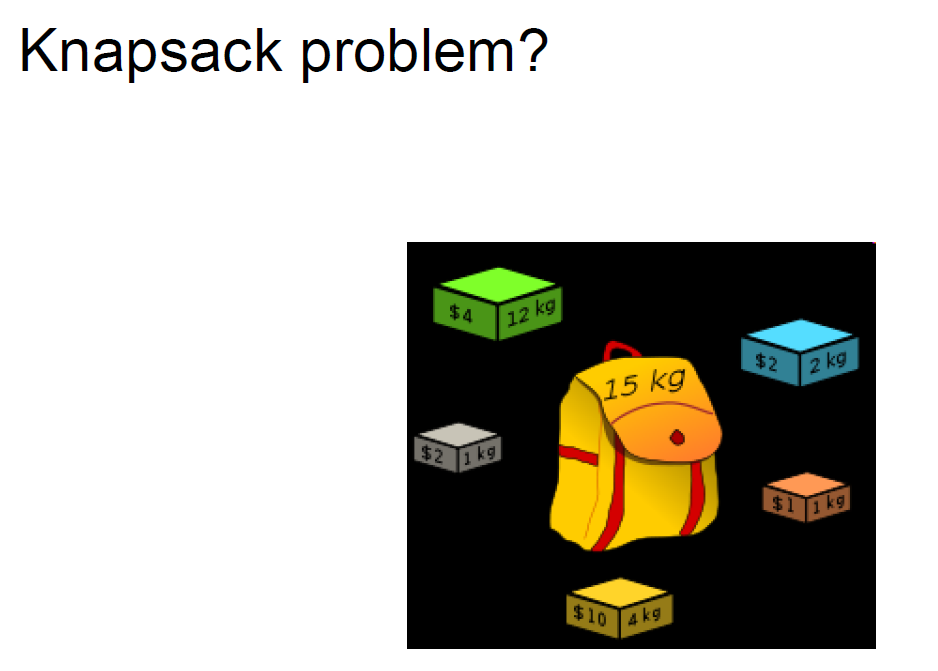

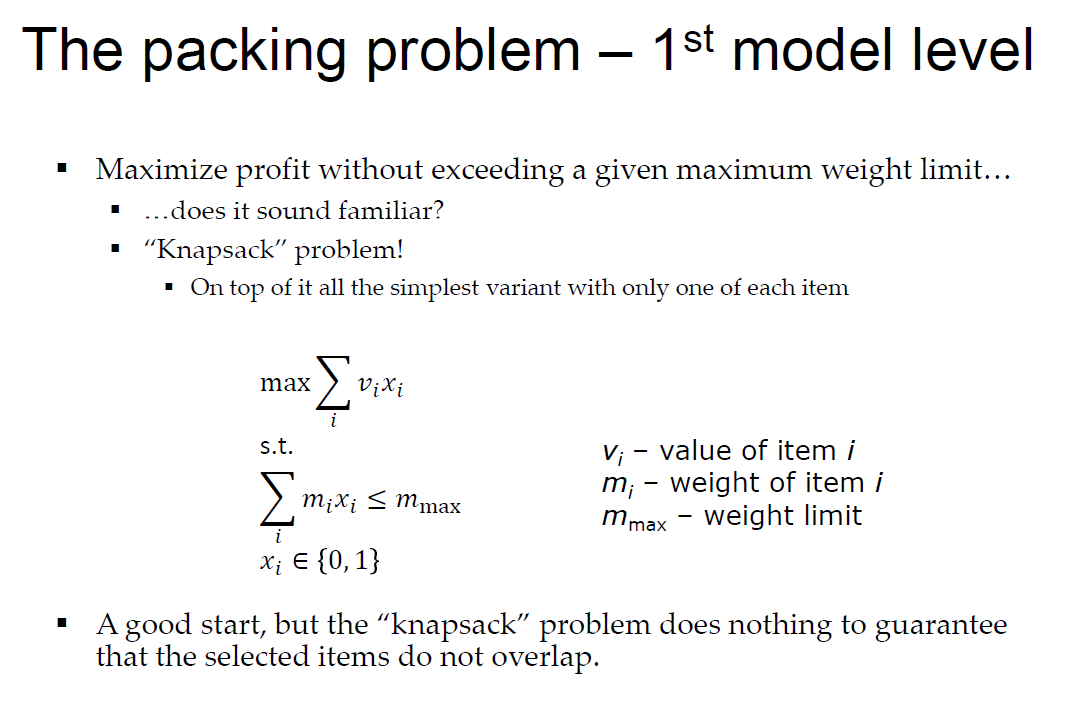

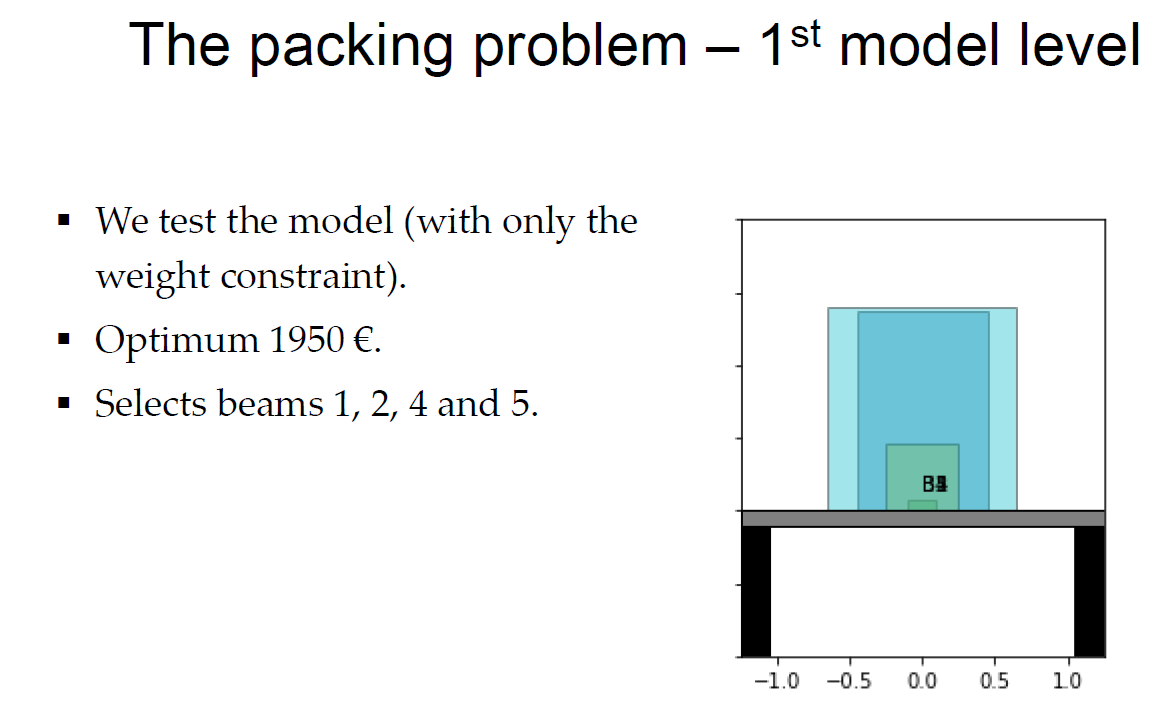

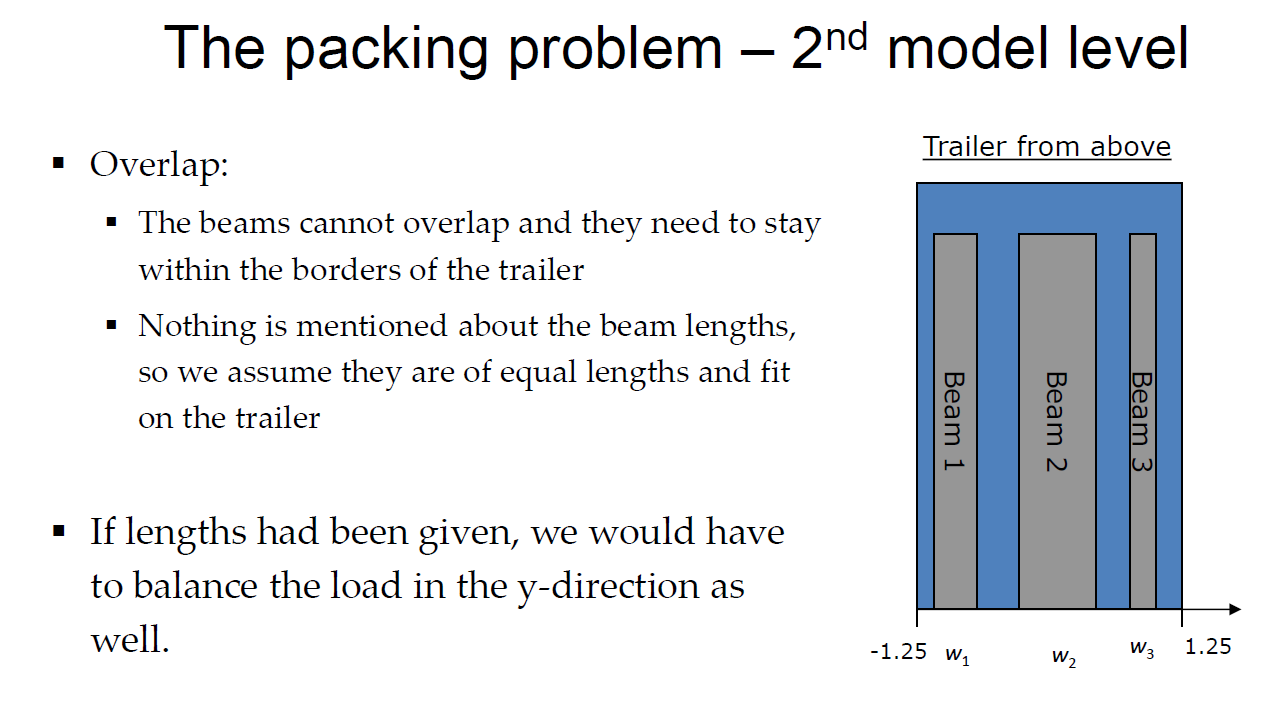

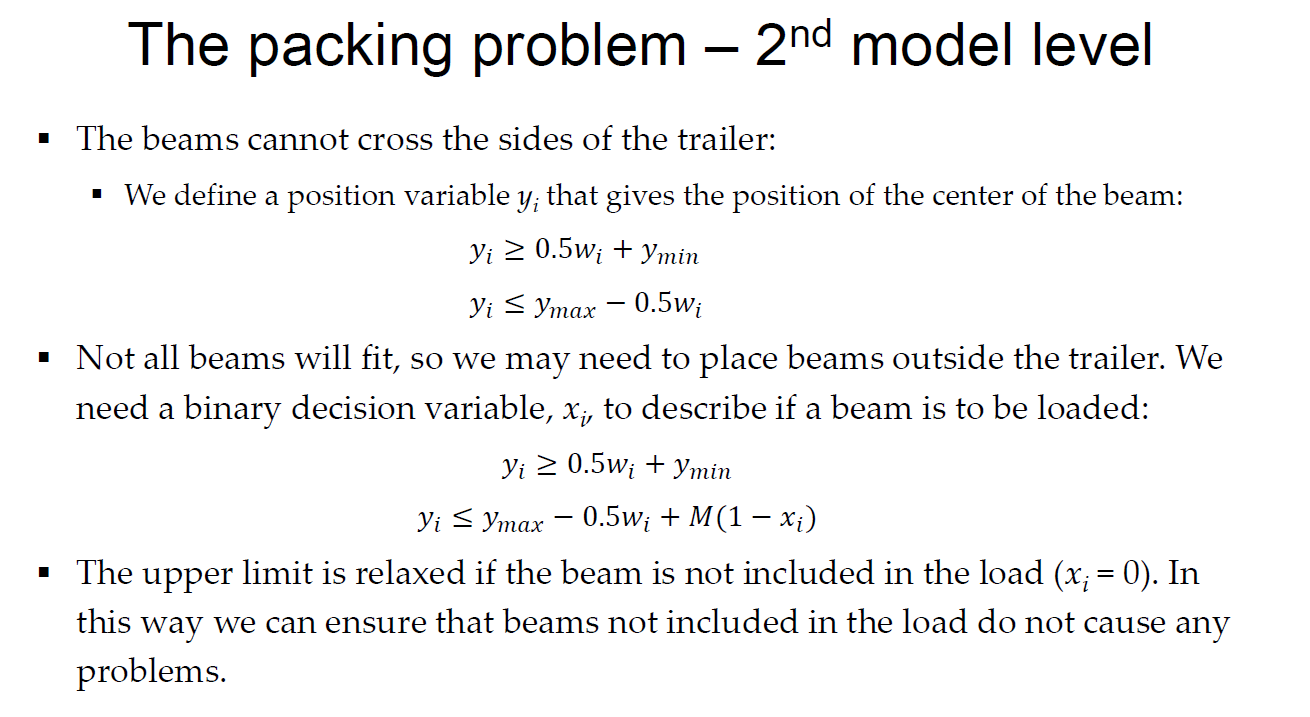

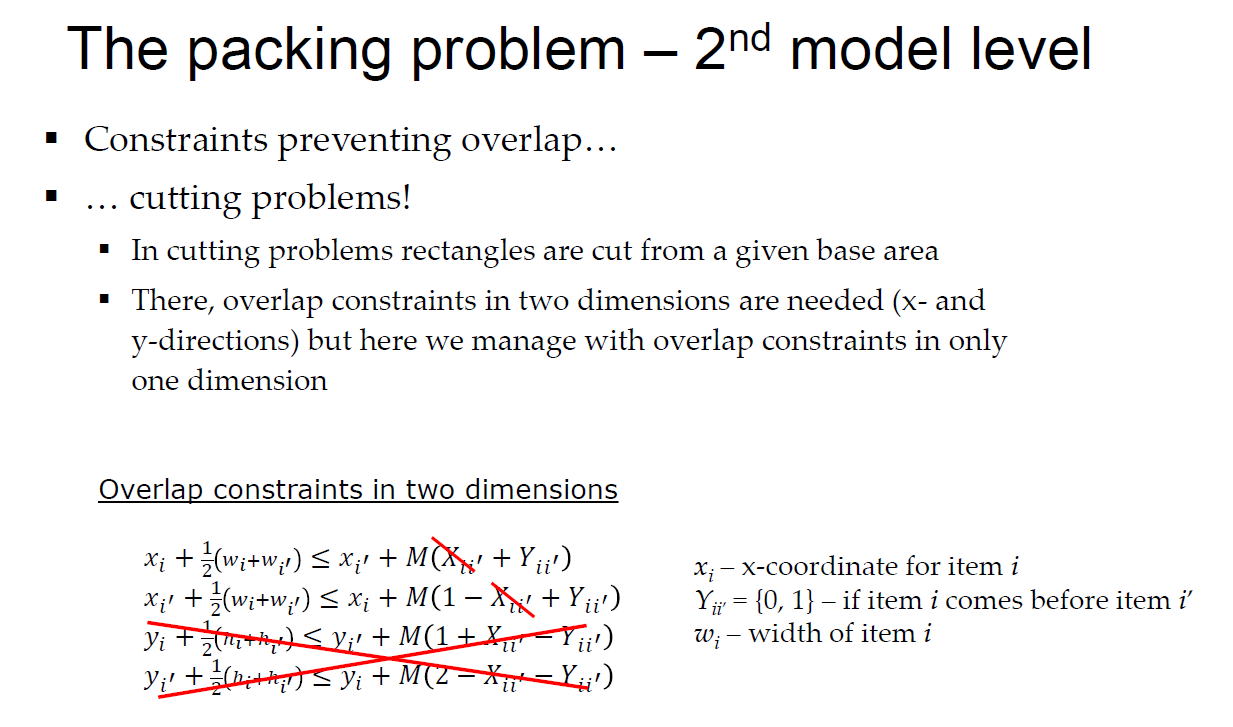

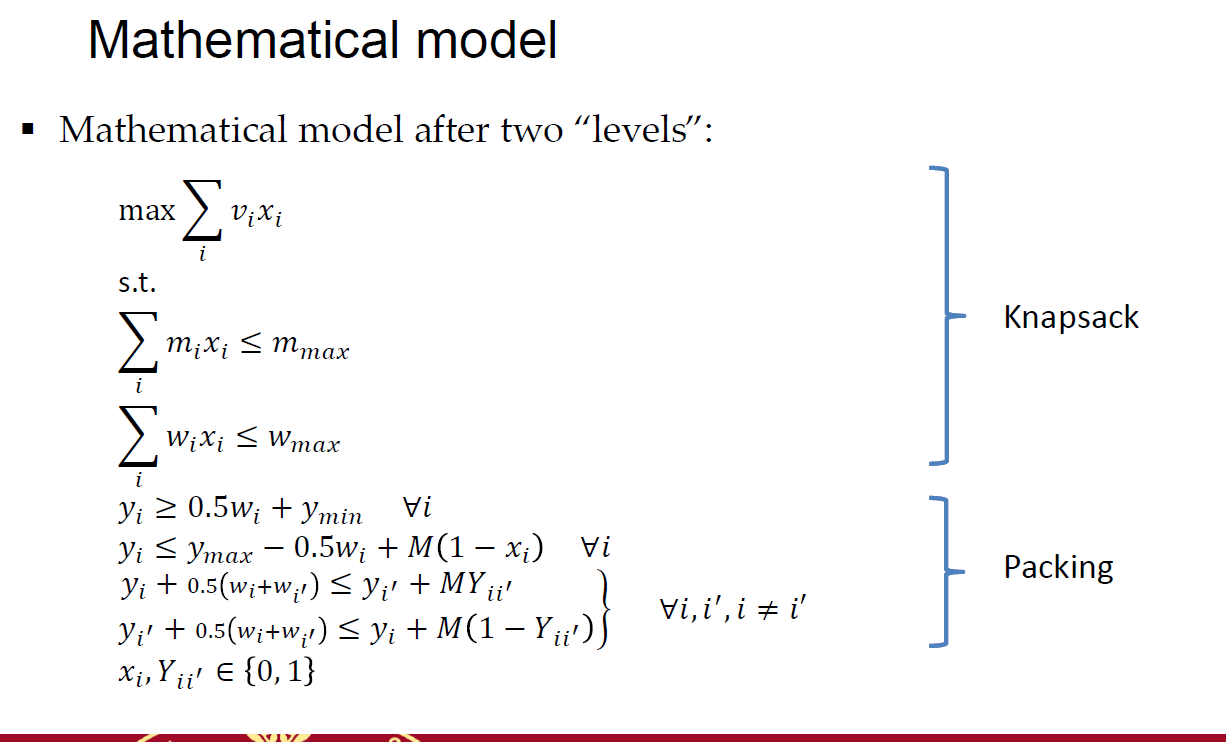

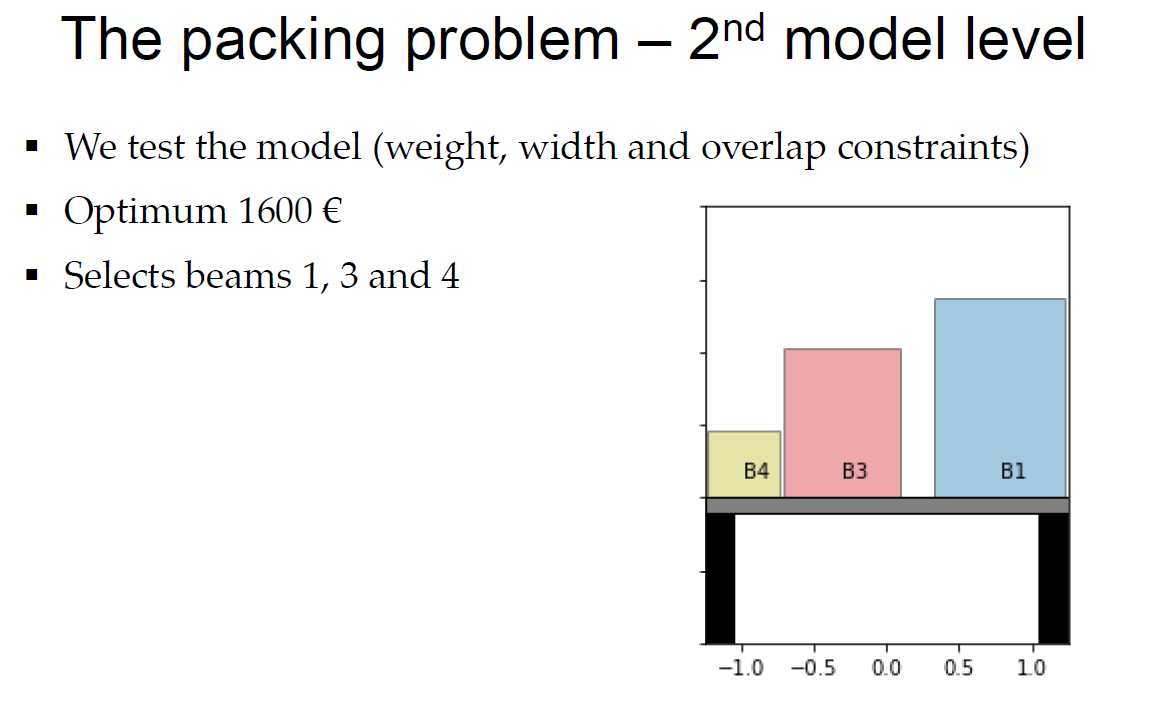

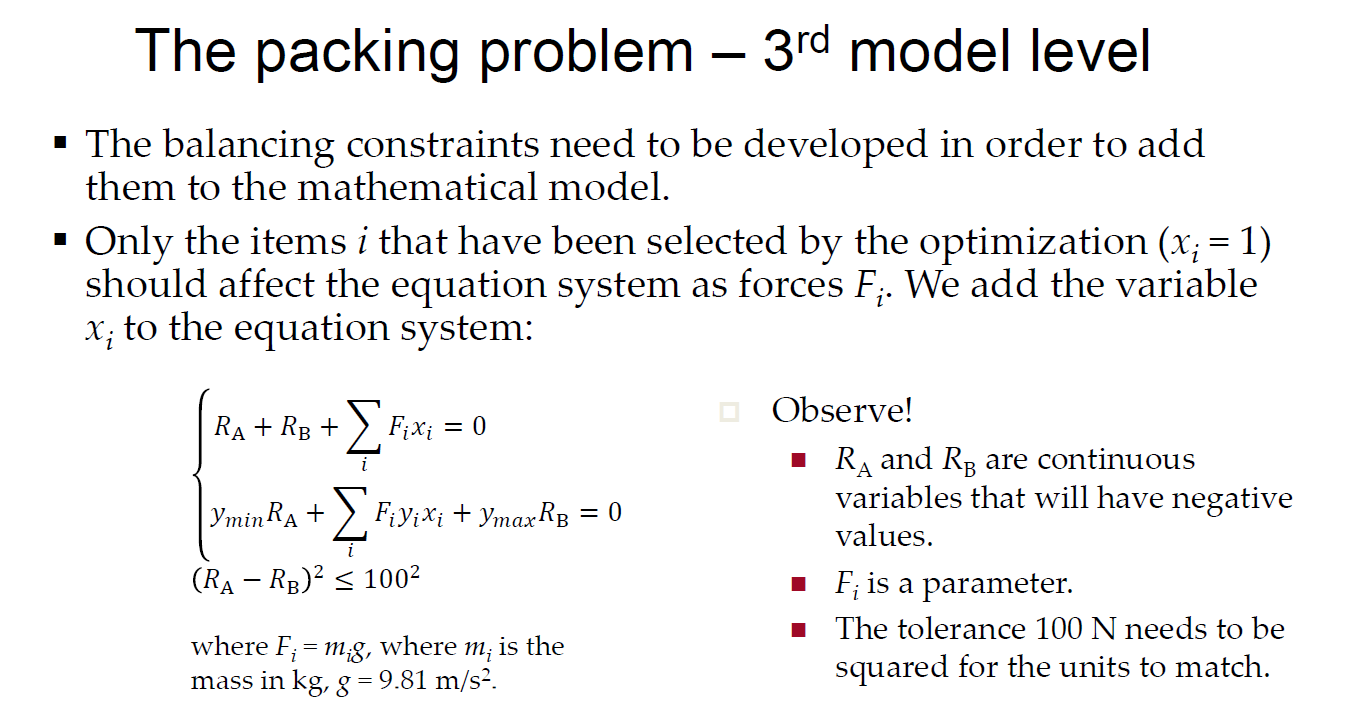

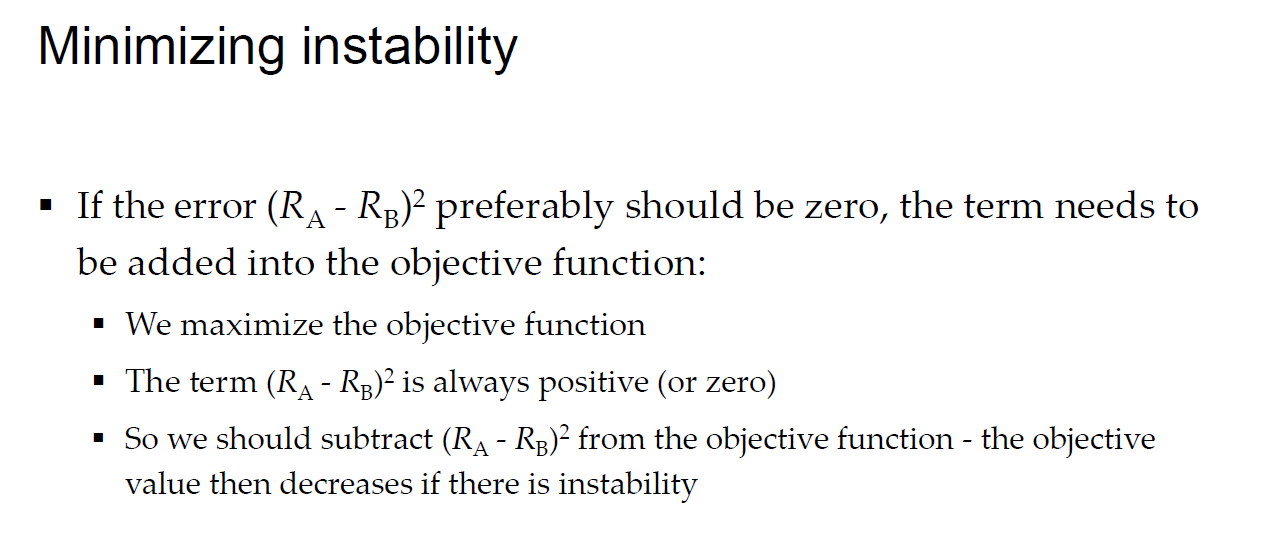

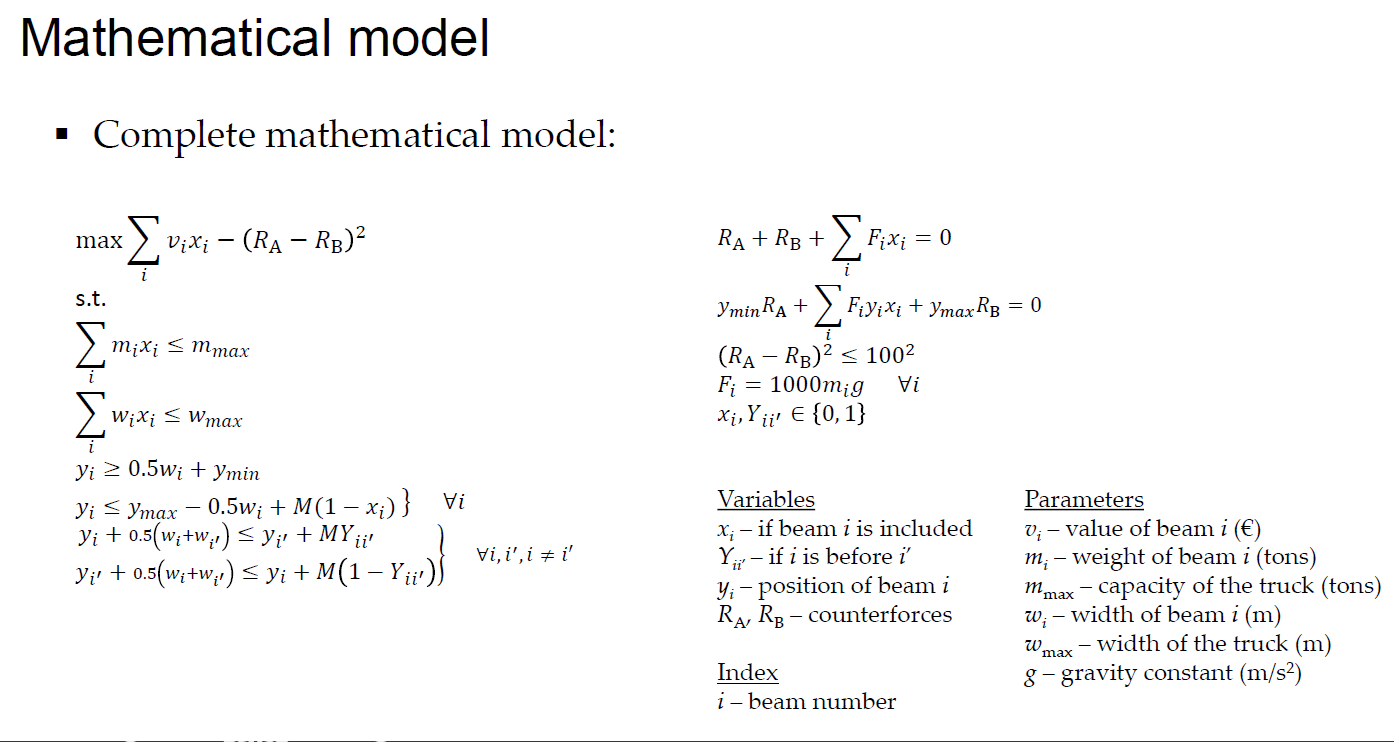

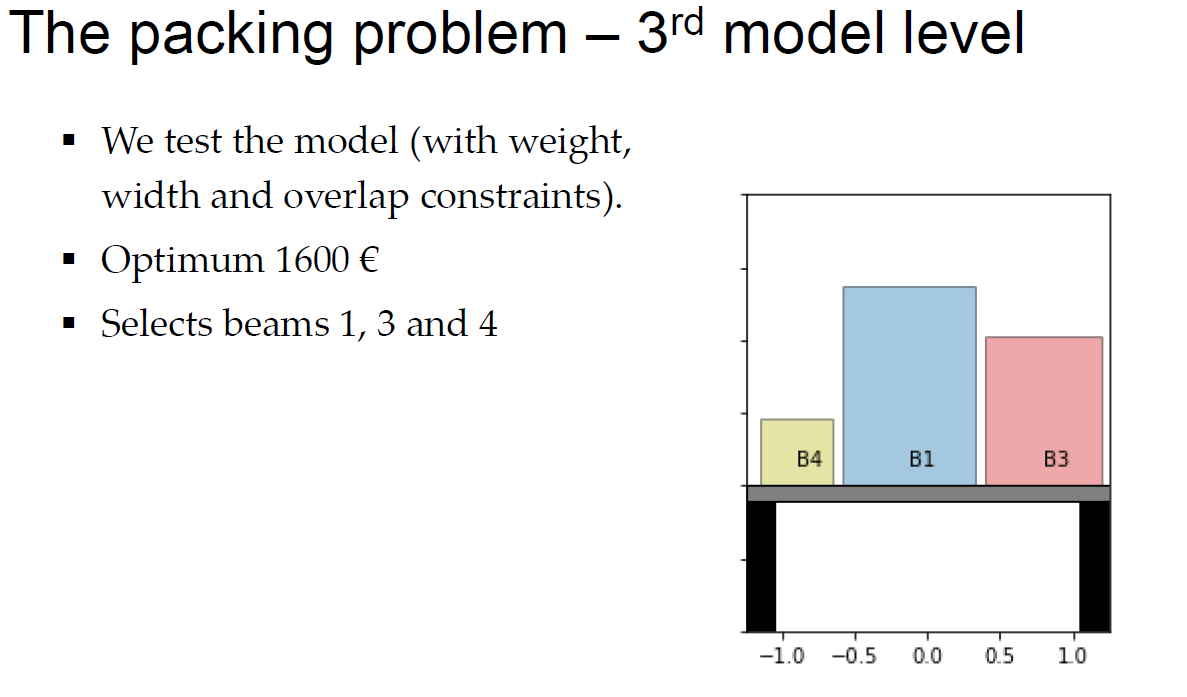

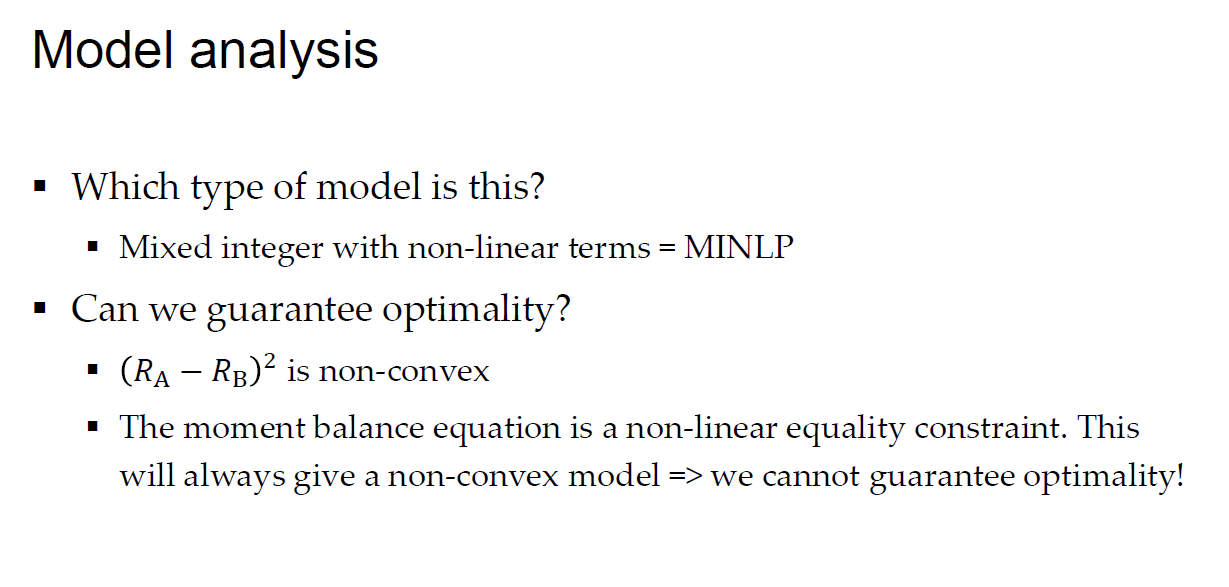

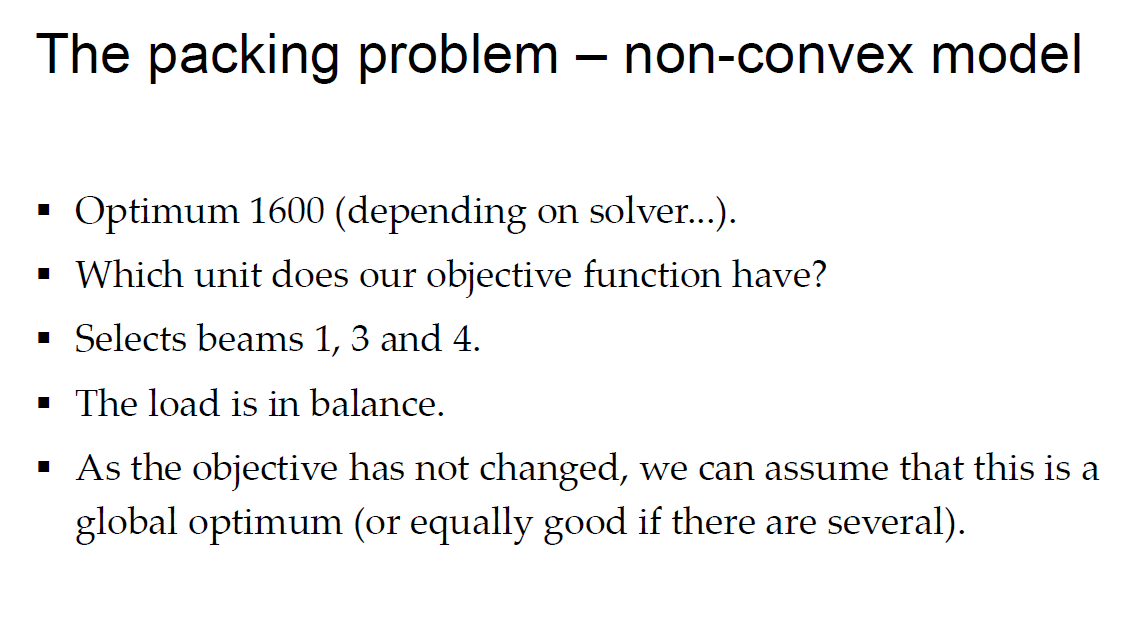

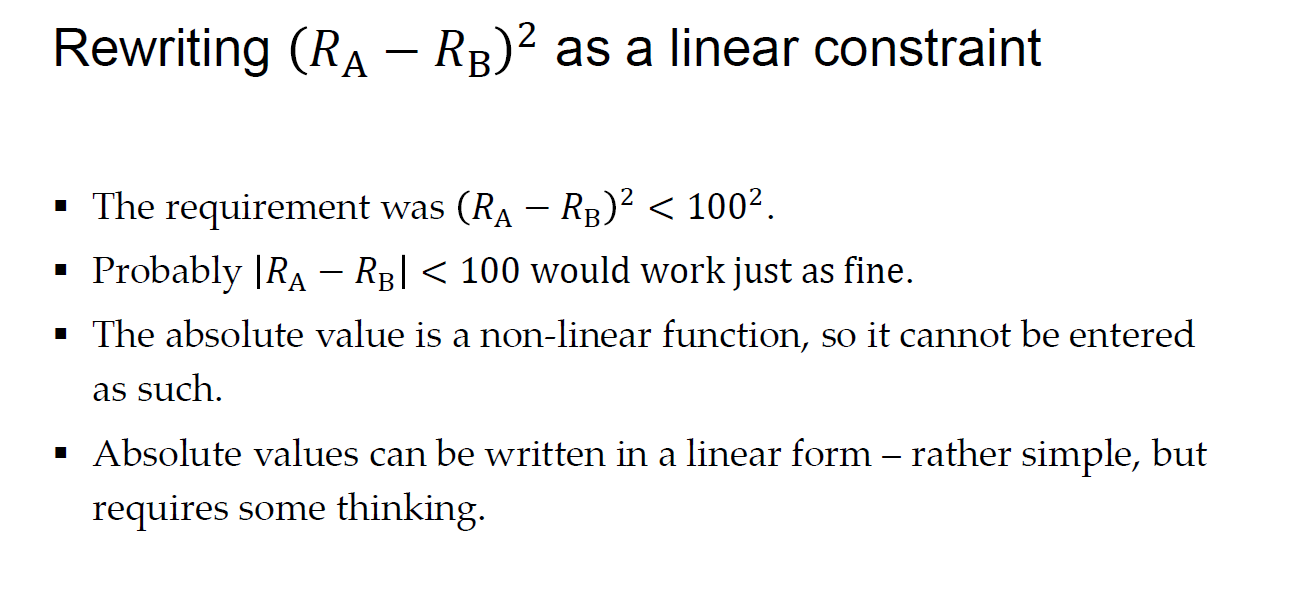

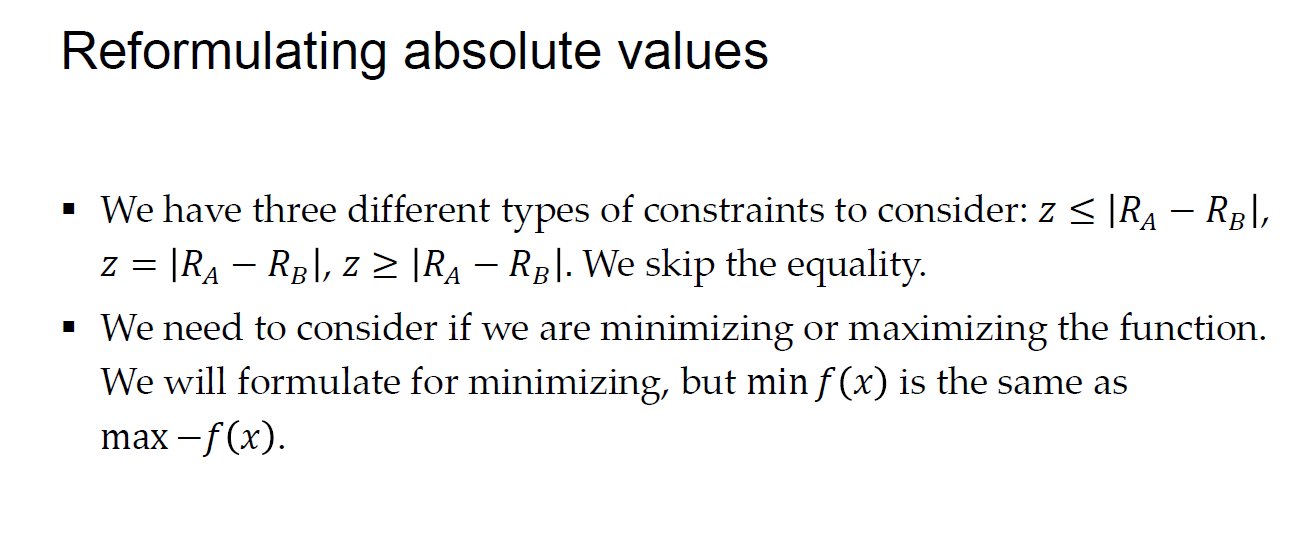

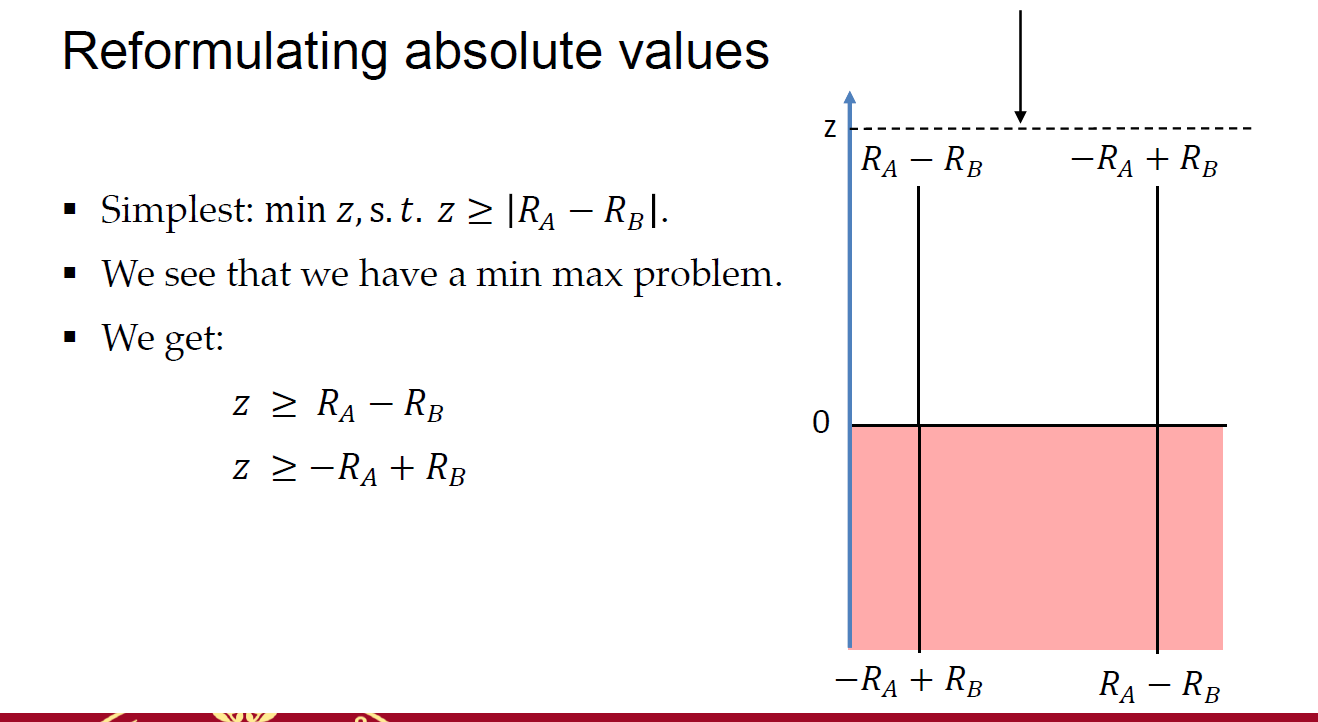

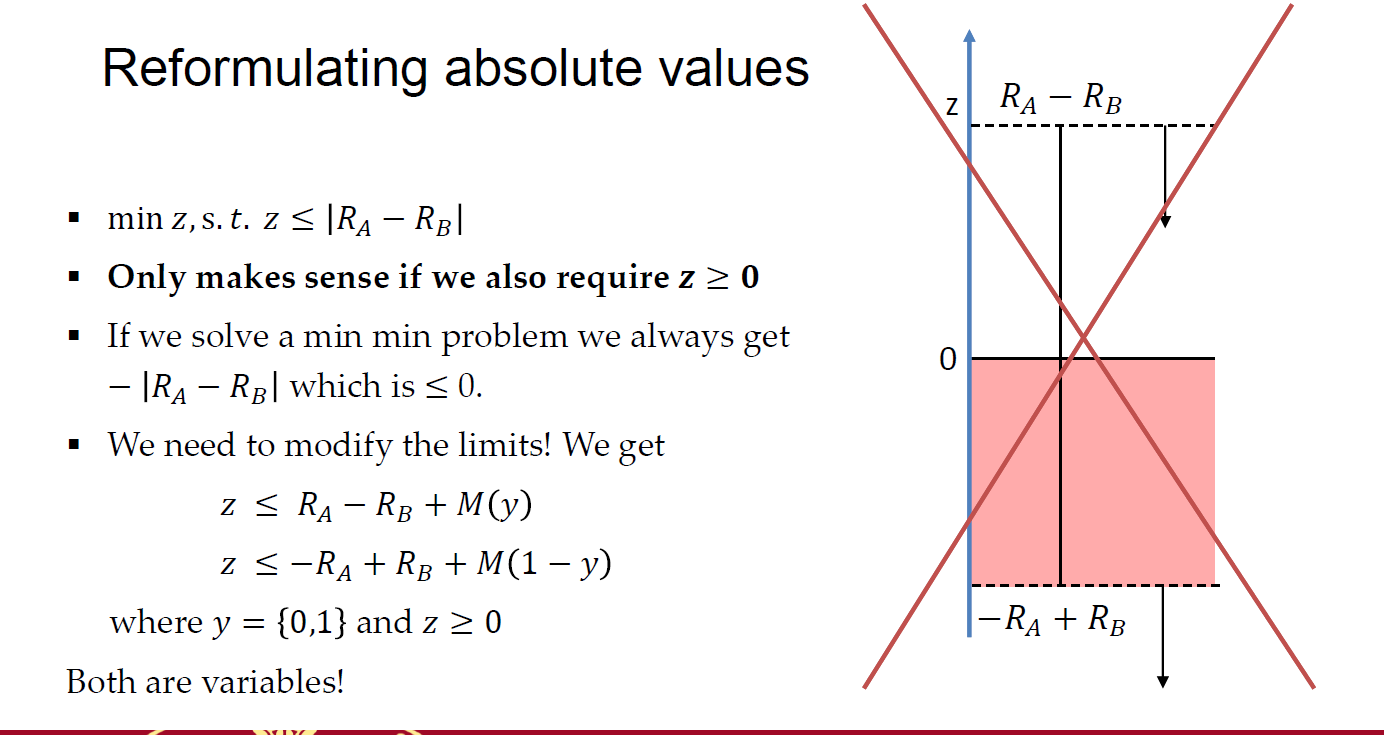

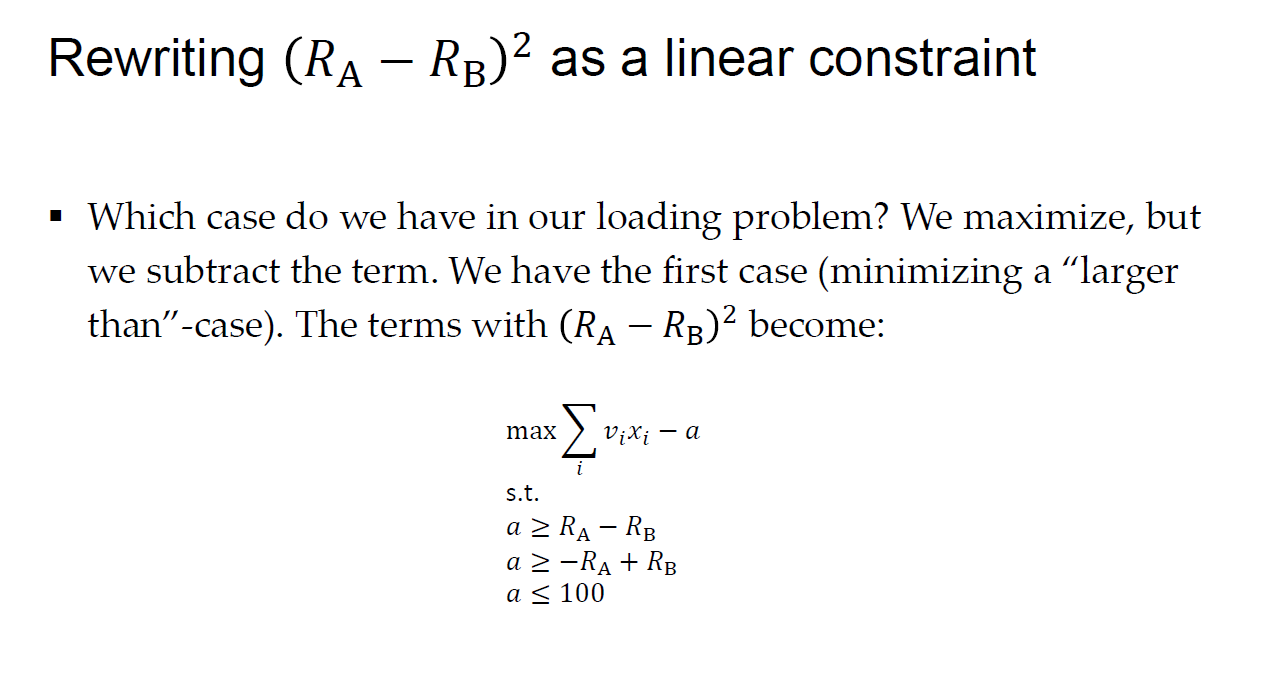

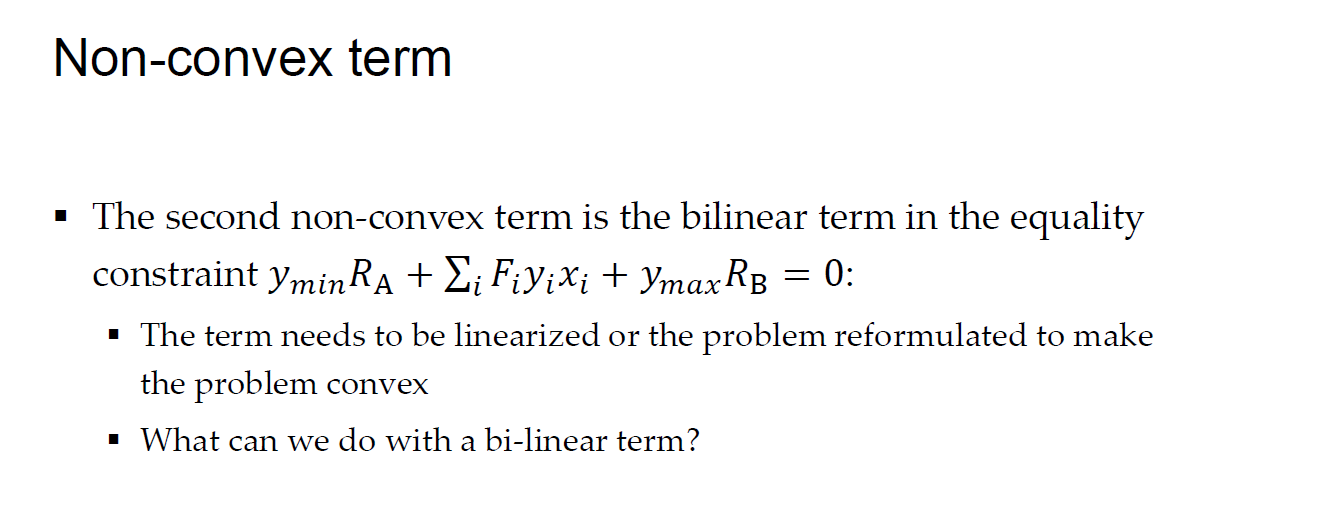

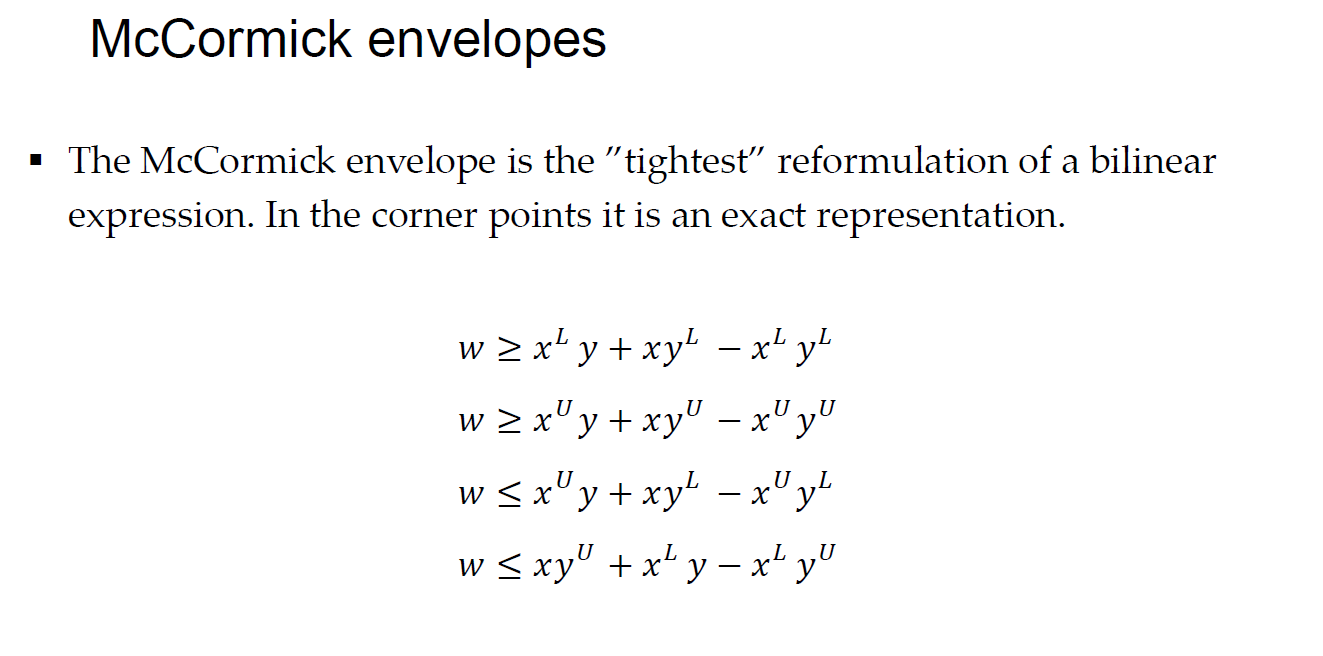

Solution time: 0.044783 s
Value 1 1950.0
beam B1 center position 0
beam B2 center position 0
beam B3 center position 0 not included
beam B4 center position 0
beam B5 center position 0


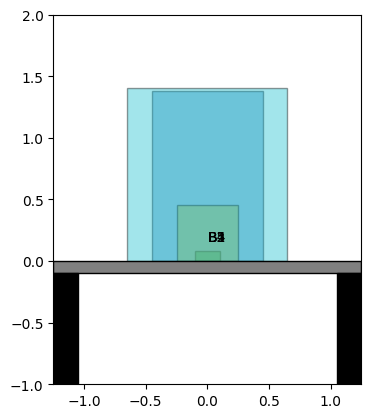

Solution time: 0.14509 s
Value 1b  1600.0
beam B1 center position 0
beam B2 center position 0 not included
beam B3 center position 0
beam B4 center position 0
beam B5 center position 0 not included


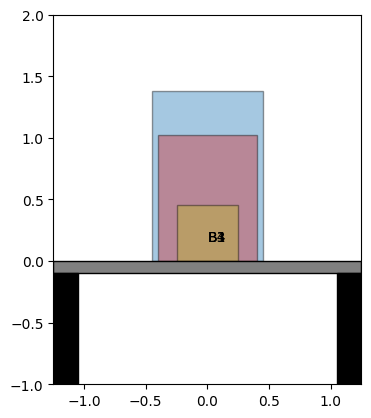

Solution time: 0.360481 s
Value 2 1600.0
beam B1 center position 0.7820791826353599
beam B2 center position 0.21208199277134454 not included
beam B3 center position -0.3089232176211488
beam B4 center position -0.9791100171473478
beam B5 center position 5.213490313982356 not included


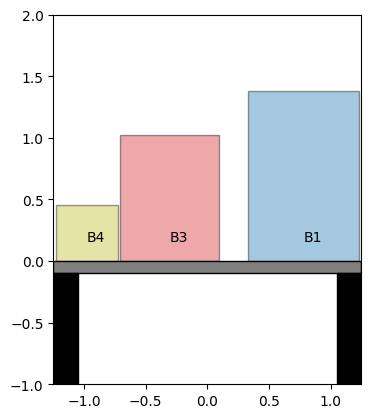

Solution time: 3.268456 s
Value full 1600.0
beam B1 center position -0.12514501863446761
beam B2 center position 4.017730576747302 not included
beam B3 center position 0.7918506312635478
beam B4 center position -0.9034032192380284
beam B5 center position 6.217759302595466 not included


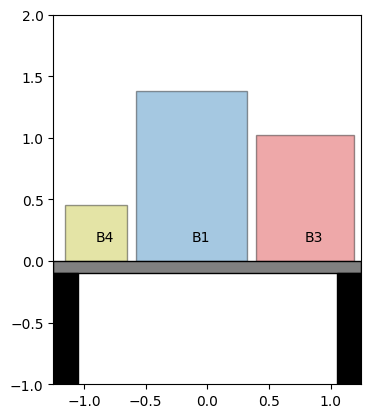

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 23 14:53:20 2024

@author: abrink
"""
from pyomo.environ import *
import matplotlib.pyplot as plt
import datetime

def plot_load(m):
    #Plot the result (only one "subplot" specified)
    figure, axes = plt.subplots()

    c={'B1':'tab:blue','B2':'tab:green','B3':'tab:red','B4':'tab:olive','B5':'tab:cyan'}
    for i in m.i:
        if m.x[i].value == 1:
            left=m.y[i].value-0.5*m.w[i]
            p = plt.Rectangle((left,0), m.w[i],m.m[i]*m.w[i]/10000, fill=True, facecolor=c[i],edgecolor='black',alpha=0.4)
            axes.add_artist(p)
            axes.text(left+m.w[i]/2, 0.5/2, i,
                 horizontalalignment='left', verticalalignment='top')

    p = plt.Rectangle((m.ymin,0), m.ymax-m.ymin,-0.1, fill=True, facecolor='gray',edgecolor='black')
    axes.add_artist(p)
    p = plt.Rectangle((m.ymin,-1), 0.2,0.9, fill=True, color='black',)
    axes.add_artist(p)
    p = plt.Rectangle((m.ymax-0.2,-1), 0.2,0.9, fill=True, color='black',)
    axes.add_artist(p)
    axes.set_aspect(1)
    plt.xlim(m.ymin,m.ymax)
    plt.ylim(-1,2)
    plt.show()


m=ConcreteModel()
m.i=Set(initialize=['B1','B2','B3','B4','B5'])
m.m=Param(m.i,initialize={'B1':15300,'B2':3900,'B3':12800,'B4':9100,'B5':10800})
m.w=Param(m.i,initialize={'B1':0.9,'B2':0.2,'B3':0.8,'B4':0.5,'B5':1.3})
m.v=Param(m.i,initialize={'B1':700,'B2':300,'B3':500,'B4':400,'B5':550})
#Lazy hooking
m.wmax=40000
m.ymin=-1.25
m.ymax=1.25

m.x=Var(m.i,within=Binary,doc='Include?')
m.y=Var(m.i,within=Reals,bounds=(-1.25,None),initialize=0)

m.o=Objective(expr=sum(m.v[i]*m.x[i] for i in m.i),sense=maximize)

m.cw=Constraint(expr=sum(m.m[i]*m.x[i] for i in m.i) <= m.wmax, doc='Max weight')

solver = SolverFactory('bonmin')
ts=datetime.datetime.now()
solver = SolverFactory('bonmin')
results = solver.solve(m,tee=False)
te=datetime.datetime.now()

print('Solution time:',(te-ts).seconds+(te-ts).microseconds/1e6,'s')


print('Value 1', m.o.expr())
for i in m.i:
    if m.x[i].value==1:
        print('beam',i,'center position',m.y[i].value)
    else:
        print('beam',i,'center position',m.y[i].value, 'not included')

plot_load(m)

#Model 1b
m.cl = Constraint(expr=sum(m.w[i]*m.x[i] for i in m.i) <= m.ymax-m.ymin, doc='Max width')

solver = SolverFactory('bonmin')
ts=datetime.datetime.now()
solver = SolverFactory('bonmin')
results = solver.solve(m,tee=False)
te=datetime.datetime.now()

print('Solution time:',(te-ts).seconds+(te-ts).microseconds/1e6,'s')
print('Value 1b ', m.o.expr())
for i in m.i:
    if m.x[i].value==1:
        print('beam',i,'center position',m.y[i].value)
    else:
        print('beam',i,'center position',m.y[i].value, 'not included')

plot_load(m)


m.Y = Var(m.i,m.i,within=Binary,doc='Relative position')
m.BigM=10

def co1_rule(m,i):
    return m.y[i] >= 0.5*m.w[i]+m.ymin

m.co1 = Constraint(m.i,rule=co1_rule, doc='Left boundary')

def co2_rule(m,i):
    return m.y[i] <= m.ymax - 0.5*m.w[i] + m.BigM*(1-m.x[i])

m.co2 = Constraint(m.i,rule=co2_rule, doc='Right boundary')

def co3_rule(m,i,ip):
    if i < ip:
        return m.y[i] + 0.5*(m.w[i]+m.w[ip]) <= m.y[ip] + m.BigM*m.Y[i,ip]
    else:
        return Constraint.Skip

m.co3 = Constraint(m.i,m.i,rule=co3_rule, doc='Overlap 1')

def co4_rule(m,i,ip):
    if i < ip:
        return m.y[ip] + 0.5*(m.w[i]+m.w[ip]) <= m.y[i] + m.BigM*(1-m.Y[i,ip])
    else:
        return Constraint.Skip

m.co4 = Constraint(m.i,m.i,rule=co4_rule, doc='Overlap 1')

ts=datetime.datetime.now()
solver =SolverFactory('bonmin')
results = solver.solve(m,tee=False)
te=datetime.datetime.now()

print('Solution time:',(te-ts).seconds+(te-ts).microseconds/1e6,'s')
print('Value 2', m.o.expr())
for i in m.i:
    if m.x[i].value==1:
        print('beam',i,'center position',m.y[i].value)
    else:
        print('beam',i,'center position',m.y[i].value, 'not included')

plot_load(m)

m.g = 9.81

m.R_A = Var(within=Reals)
m.R_B = Var(within=Reals)

#Change objective (could in this case be done with m.o.expr += ....)

m.o.deactivate()
m.o2=Objective(expr=sum(m.v[i]*m.x[i] for i in m.i)-(m.R_A-m.R_B)**2,sense=maximize)
m.o2.activate()

m.cf = Constraint(expr=m.R_A + m.R_B + sum(m.g*m.m[i]*m.x[i] for i in m.i) == 0)
m.cn =Constraint(expr=m.ymin*m.R_A+sum(m.g*m.m[i]*m.y[i]*m.x[i] for i in m.i)+m.ymax*m.R_B == 0)
m.ci = Constraint(expr=(m.R_A-m.R_B)**2 <= 100**2)

ts=datetime.datetime.now()
solver = SolverFactory('bonmin')
results = solver.solve(m,tee=False)
te=datetime.datetime.now()

print('Solution time:',(te-ts).seconds+(te-ts).microseconds/1e6,'s')
print('Value full', m.o.expr())
for i in m.i:
    if m.x[i].value==1:
        print('beam',i,'center position',m.y[i].value)
    else:
        print('beam',i,'center position',m.y[i].value, 'not included')

plot_load(m)
